# **Introduction**

Exploratory Data Analysis of Sendy Logistics Challenge by EXPLORE Data Science Academy

Logistics in Sub-Saharan Africa increases the cost of manufactured goods by up to 320%; while in Europe, it only accounts for up to 90% of the manufacturing cost. Economies are better when logistics is efficient and affordable.

Sendy is hosting a Zindi challenge to predict the estimated time of delivery of orders, from the point of driver pickup to the point of arrival at final destination.

The solution will improve customer experience. The solution will need to enable Sendy to realise cost savings, and ultimately reduce the cost of doing business, through improved resource management and planning for order scheduling.

The analysis will assist in understanding the data and get the insights about the variables that affect the time taken from pick up to arrival, making better predicts.

#**Body**
##**1. Exploratory Data Analysis (EDA)**

###**1.1. Importing libraries**

In [ ]:
pip install reverse_geocoder catboost

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import requests
import reverse_geocoder as rg
np.random.seed(123)
warnings.filterwarnings('ignore')
%matplotlib inline

###**1.2. Uploading the dataset files**

In [ ]:
train_1 = pd.read_csv("Train.csv")
test_1 = pd.read_csv("Test.csv")
riders_1 = pd.read_csv("Riders.csv")

In [39]:
train_df = train_1.copy()
train_df.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Pickup - Time,Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,9:40:10 AM,9,5,10:04:47 AM,9,5,10:27:30 AM,9,5,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,11:23:21 AM,12,5,11:40:22 AM,12,5,11:44:09 AM,12,5,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,12:42:44 PM,30,2,12:49:34 PM,30,2,12:53:03 PM,30,2,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,9:26:05 AM,15,5,9:37:56 AM,15,5,9:43:06 AM,15,5,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,9:56:18 AM,13,1,10:03:53 AM,13,1,10:05:23 AM,13,1,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


The dataset have the columns Vehicle Type, User Id and Personal or Business, Precipitation in millimeters which we believe will not have so much impact on the estimated time from pick up to arrival. Out of the remaining variables, Order No, User Id are categorical variables and the remaining variables i.e. Placement - Day of Month, Arrival at Destination - Time, Distance (KM) and Temperature are numerical variables.

In [ ]:
mean_t = train_df['Temperature'].mean()
train_df['Temperature'] = train_df['Temperature'].fillna(mean_t)

In [ ]:
mean_p = train_df['Precipitation in millimeters'].mean()
train_df['Precipitation in millimeters'] = train_df['Precipitation in millimeters'].fillna(mean_p)

In [ ]:
train_df["Rider Id"] = train_df["Rider Id"].str.get(-1)

In [ ]:
train_df["Order No"] = train_df["Order No"].str.split("_").str.get(-1)

In [ ]:
train_df["User Id"] = train_df["User Id"].str.split("_").str.get(-1)

In [ ]:
train_df = train_df.set_index(keys = ["Order No"])

In [ ]:
dataset = train_df[["Platform Type", "Placement - Day of Month", "Placement - Weekday (Mo = 1)", "Confirmation - Day of Month","Confirmation - Weekday (Mo = 1)", "Arrival at Pickup - Day of Month","Arrival at Pickup - Weekday (Mo = 1)", "Pickup - Day of Month","Pickup - Weekday (Mo = 1)", "Distance (KM)", "Temperature", "Time from Pickup to Arrival"]]

In [14]:
dataset

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Time from Pickup to Arrival
0,3,9,5,9,5,9,5,9,5,4,20.400000,745
1,3,12,5,12,5,12,5,12,5,16,26.400000,1993
2,3,30,2,30,2,30,2,30,2,3,23.258889,455
3,3,15,5,15,5,15,5,15,5,9,19.200000,1341
4,1,13,1,13,1,13,1,13,1,9,15.400000,1214
...,...,...,...,...,...,...,...,...,...,...,...,...
21196,3,20,3,20,3,20,3,20,3,3,28.600000,9
21197,3,13,6,13,6,13,6,13,6,7,26.000000,770
21198,3,7,4,7,4,7,4,7,4,20,29.200000,2953
21199,1,4,3,4,3,4,3,4,3,13,15.000000,1380


In [15]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Platform Type,21201.0,2.752182,0.625178,1.0,3.0,3.000000,3.0,4.0
Placement - Day of Month,21201.0,15.653696,8.798916,1.0,8.0,15.000000,23.0,31.0
Placement - Weekday (Mo = 1),21201.0,3.240083,1.567295,1.0,2.0,3.000000,5.0,7.0
Confirmation - Day of Month,21201.0,15.653837,8.798886,1.0,8.0,15.000000,23.0,31.0
Confirmation - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.0,2.0,3.000000,5.0,7.0
Arrival at Pickup - Day of Month,21201.0,15.653837,8.798886,1.0,8.0,15.000000,23.0,31.0
Arrival at Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.0,2.0,3.000000,5.0,7.0
Pickup - Day of Month,21201.0,15.653837,8.798886,1.0,8.0,15.000000,23.0,31.0
Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.0,2.0,3.000000,5.0,7.0
Distance (KM),21201.0,9.506533,5.668963,1.0,5.0,8.000000,13.0,49.0


###**1.3. Checking the mathematical relationships**
We firsty check linearity which is the mathematical relationship between each predictor variable and the response variable.


> Indented block


If we fit the regression model to a dataset that is non-linear, it will fail to adequately capture the relationship in the data - resulting in a mathematically inappropriate model. In order to check for linearity, we can produce scatter plots of each individual predictor against the response variable. The intuition here is that we are looking for obvious linear relationships.

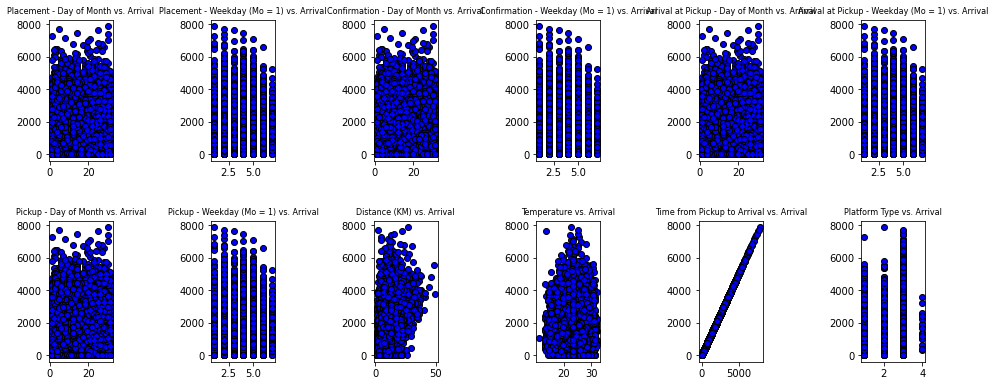

In [16]:
fig, axs = plt.subplots(2,6, figsize=(14,6),)
fig.subplots_adjust(hspace = 0.5, wspace=.2)
axs = axs.ravel()

for index, column in enumerate(dataset.columns):
    axs[index-1].set_title("{} vs. Arrival".format(column),fontsize=8)
    axs[index-1].scatter(x=dataset[column],y=dataset['Time from Pickup to Arrival'],color='blue',edgecolor='k')

fig.tight_layout(pad=3)

It appears that at least half of the variables have an approximately linear relationship. However, Temperature exhibit no linearity with Time from Pickup to Arrival.

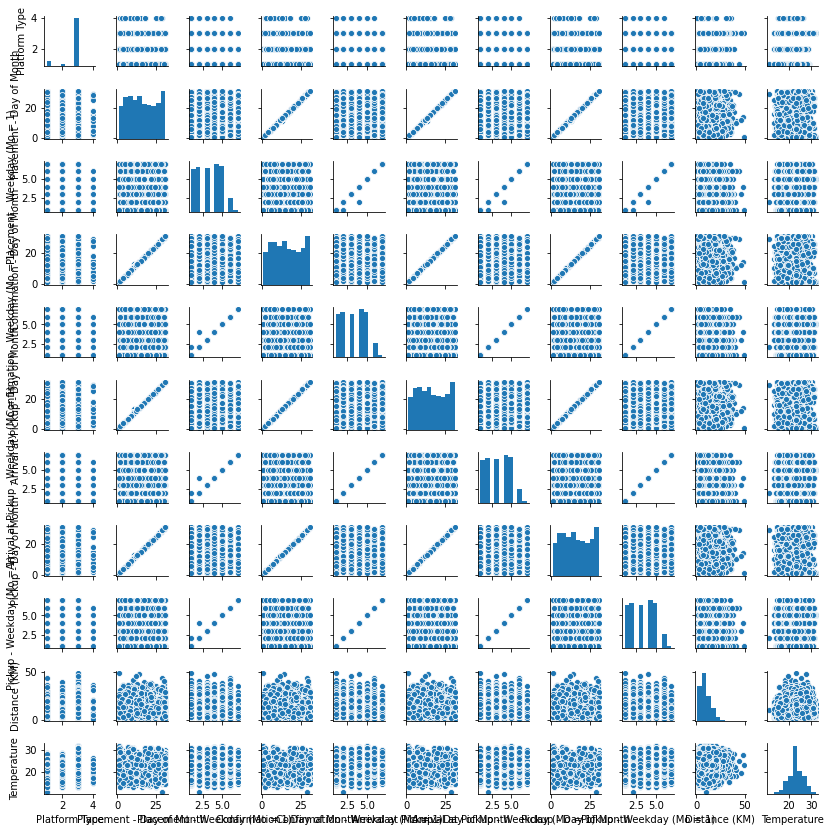

In [17]:
from seaborn import pairplot
g = pairplot(dataset.drop('Time from Pickup to Arrival', axis='columns'))
g.fig.set_size_inches(11,11)

In [ ]:
corr = dataset.drop('Time from Pickup to Arrival', axis='columns').corr()

In [ ]:
from statsmodels.graphics.correlation import plot_corr

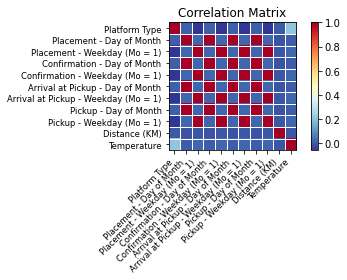

In [23]:
fig=plot_corr(corr,xnames=corr.columns)

From both the pairwise scatterplot and correlation heatmap, we can see a number of strong correlations among predictors:

    Placement - Day of Month and Arrival at Pickup - Day of Month;
    Arrival at Pickup - Day of Month and Pickup - Day of Month;
    Confirmation - Day of Month and Pickup - Day of Month;

We'll keep these in mind when we build and continue to check the quality of our model.

###**1.4. OLS Regression**

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [25]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

## fit a OLS model with intercept

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     Time from Pickup to Arrival   R-squared:                       0.337
Model:                                     OLS   Adj. R-squared:                  0.337
Method:                          Least Squares   F-statistic:                     1799.
Date:                         Tue, 02 Jun 2020   Prob (F-statistic):               0.00
Time:                                 18:21:29   Log-Likelihood:            -1.7190e+05
No. Observations:                        21201   AIC:                         3.438e+05
Df Residuals:                            21194   BIC:                         3.439e+05
Df Model:                                    6                                         
Covariance Type:                     nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                  573.8207     46.657     12.299      0.000     482.369     665.272
Platform Type                          -13.1669      9.054     -1.454      0.146     -30.914       4.580
Placement - Day of Month              -184.1041    179.731     -1.024      0.306    -536.391     168.183
Placement - Weekday (Mo = 1)          -182.6739    179.732     -1.016      0.309    -534.963     169.615
Confirmation - Day of Month             60.9763     59.911      1.018      0.309     -56.454     178.406
Confirmation - Weekday (Mo = 1)         62.4065     59.918      1.042      0.298     -55.038     179.851
Arrival at Pickup - Day of Month        60.9763     59.911      1.018      0.309     -56.454     178.406
Arrival at Pickup - Weekday (Mo = 1)    62.4065     59.918      1.042      0.298     -55.038     179.851
Pickup - Day of Month                   60.9763     59.911      1.018      0.309     -56.454     178.406
Pickup - Weekday (Mo = 1)               62.4065     59.918      1.042      0.298     -55.038     179.851
Distance (KM)                          101.1087      0.974    103.829      0.000      99.200     103.017
Temperature                              2.6553      1.754      1.513      0.130      -0.784       6.094
==============================================================================
Omnibus:                     7137.186   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33597.850
Skew:                           1.577   Prob(JB):                         0.00
Kurtosis:                       8.300   Cond. No.                     1.45e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.88e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

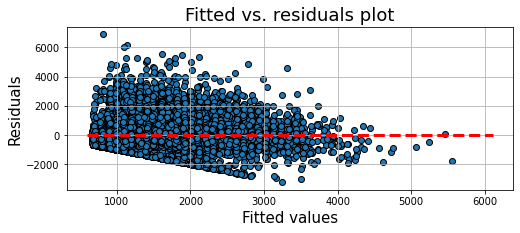

In [26]:
plt.figure(figsize=(8,3))
p=plt.scatter(x=est.fittedvalues,y=est.resid,edgecolor='k')
xmin = min(est.fittedvalues)
xmax = max(est.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

It appears the points are scattered quite a bit densely throughout and not forming a funnel shape, indicating a strong assumption of Homoscedasticity. The chances of outliers disproportionately influencing the model's performance are quite slim.

In conclusion, there are variables that correlate to assist in estimating the Time from Pickup to Arrival. This is properly showed when we train our model even further and add more variables from the dataset given.

#**2. Data Preprocessing**

In [ ]:
riders = pd.read_csv("Riders.csv", index_col = 'Rider Id')
train = pd.read_csv('Train.csv', index_col='Order No')
test = pd.read_csv('Test.csv', index_col='Order No')

##**2.1. Preprocessing of the train data**

In [ ]:
y_train = train['Time from Pickup to Arrival'].values
train.drop(["Arrival at Destination - Day of Month","Arrival at Destination - Weekday (Mo = 1)","Arrival at Destination - Time"],axis = 1,inplace =True)

##START coding rider meta data
avg_rating = []
no_ratings = []
days_worked = []
orders = []
rid = train['Rider Id'].values 
for x in rid:
    avg_rating.append(riders.at[x, 'Average_Rating']) #creates a list of average rider rating
    no_ratings.append(riders.at[x, 'No_of_Ratings']) #creates a list of total numbe rof rider ratings
    days_worked.append(riders.at[x, 'Age']) #creates a list of rider age (Days delivering)
    
train['Average Rating'] = avg_rating
train['Age'] = days_worked
train['No. of Ratings'] = no_ratings
##END coding rider meta data
train.pop('Temperature')
##START coding time hours (24hr period)
holder = []
time_binary = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']
for x in train[time_binary]:
    holder = pd.to_datetime(train[x]).dt.hour
    train[x] = holder
##END coding time hours (24hr period)


##START reverse geocoding
#Creating PICK_UP name DF
pick_up_la = train['Pickup Lat'].values 
pick_up_lo = train['Pickup Long'].values

pic_dest = pd.DataFrame(np.concatenate((pick_up_la.reshape(len(pick_up_la),1), pick_up_lo.reshape(len(pick_up_lo),1)),1))
pic_dest['GPS'] = pic_dest.apply(tuple, axis=1) #Create useable search tuple

pick_up = pic_dest['GPS'].values
searcher_pic = rg.search(list(pick_up))
pick_df = pd.DataFrame(searcher_pic) #final frame with PICK_UP LOC


#Creating DESTINATION name DF

dest_la = train['Destination Lat'].values 
dest_lo = train['Destination Long'].values

del_dest = pd.DataFrame(np.concatenate((dest_la.reshape(len(dest_la),1), dest_lo.reshape(len(dest_lo),1)),1))
del_dest['GPS'] = del_dest.apply(tuple, axis=1) #Create useable search tuple

deliveries = del_dest['GPS'].values
searcher_del = rg.search(list(deliveries))
dest_df = pd.DataFrame(searcher_del) #final frame with DEST LOC

train['Destination'] = dest_df['admin1'].values
train['Pick_up'] = pick_df['admin1'].values
## END reverse geocoding


##STAR df features to be removed
train.pop('Time from Pickup to Arrival')
train.pop('User Id')
train.pop('Placement - Day of Month')
train.pop('Confirmation - Day of Month')
train.pop('Arrival at Pickup - Day of Month')
train.pop('Pickup - Day of Month')
train.pop('Personal or Business')
train.pop('Pickup Lat')
train.pop('Pickup Long')
train.pop('Destination Lat')
train.pop('Destination Long')
train.pop('Rider Id')
train.pop('Precipitation in millimeters')
train.pop('Pickup - Weekday (Mo = 1)')
train.pop('Placement - Weekday (Mo = 1)')
train.pop('Destination')
train.pop('Vehicle Type')
train.pop('Pick_up')
##END df features to be removed

x_train = train.values


##**Checking the preprocessed data**

In [42]:
train.columns

Index(['Platform Type', 'Placement - Time', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Weekday (Mo = 1)',
       'Arrival at Pickup - Time', 'Pickup - Time', 'Distance (KM)',
       'Average Rating', 'Age', 'No. of Ratings'],
      dtype='object')

In [43]:
test.columns

Index(['User Id', 'Vehicle Type', 'Platform Type', 'Personal or Business',
       'Placement - Day of Month', 'Placement - Weekday (Mo = 1)',
       'Placement - Time', 'Confirmation - Day of Month',
       'Confirmation - Weekday (Mo = 1)', 'Confirmation - Time',
       'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Precipitation in millimeters',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id'],
      dtype='object')

In [46]:
train.head()

,Platform Type,Placement - Time,Confirmation - Weekday (Mo = 1),Confirmation - Time,Arrival at Pickup - Weekday (Mo = 1),Arrival at Pickup - Time,Pickup - Time,Distance (KM),Average Rating,Age,No. of Ratings
Order No,,,,,,,,,,,
Order_No_4211,3,9,5,9,5,10,10,4,13.8,1309,549
Order_No_25375,3,11,5,11,5,11,11,16,13.6,339,69
Order_No_1899,3,12,2,12,2,12,12,3,12.5,242,114
Order_No_9336,3,9,5,9,5,9,9,9,14.5,283,113
Order_No_27883,1,9,1,9,1,10,10,9,14.1,872,533


In [47]:
train.shape

(21201, 11)

In [ ]:
dataset = train[['Platform Type', 'Placement - Time', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Weekday (Mo = 1)',
       'Arrival at Pickup - Time', 'Pickup - Time', 'Distance (KM)',
       'Average Rating', 'Age', 'No. of Ratings']]

In [49]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Platform Type,21201.0,2.752182,0.625178,1.0,3.0,3.0,3.0,4.0
Placement - Time,21201.0,12.326824,2.541007,0.0,10.0,12.0,14.0,22.0
Confirmation - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.0,2.0,3.0,5.0,7.0
Confirmation - Time,21201.0,12.447998,2.556059,0.0,10.0,12.0,14.0,22.0
Arrival at Pickup - Weekday (Mo = 1),21201.0,3.240225,1.567228,1.0,2.0,3.0,5.0,7.0
Arrival at Pickup - Time,21201.0,12.663223,2.558333,0.0,11.0,13.0,15.0,23.0
Pickup - Time,21201.0,12.873214,2.551666,0.0,11.0,13.0,15.0,23.0
Distance (KM),21201.0,9.506533,5.668963,1.0,5.0,8.0,13.0,49.0
Average Rating,21201.0,13.882520,0.916071,0.0,13.6,14.0,14.3,15.2
Age,21201.0,984.742842,646.652835,96.0,495.0,872.0,1236.0,3764.0


##**2.3. Preprocessing of the test data**

In [ ]:
##START coding time hours (24hr period)
holder2 = []
time_binary2 = ['Placement - Time', 'Confirmation - Time', 'Arrival at Pickup - Time', 'Pickup - Time']
for x in test[time_binary2]:
    holder2 = pd.to_datetime(test[x]).dt.hour
    test[x] = holder2
##END coding time hours (24hr period)

##START coding rider meta data
avg_rating2 = []
no_ratings2 = []
days_worked2 = []
rid2 = test['Rider Id'].values 
for x in rid2:
    avg_rating2.append(riders.at[x, 'Average_Rating']) #creates a list of average rider rating
    no_ratings2.append(riders.at[x, 'No_of_Ratings']) #creates a list of total numbe rof rider ratings
    days_worked2.append(riders.at[x, 'Age']) #creates a list of rider age (Days delivering)

test['Average Rating'] = avg_rating2
test['Age'] = days_worked2
test['No. of Ratings'] = no_ratings2
##END coding rider meta data


##START reverse geocoding
#Creating PICK_UP name DF
pick_up_la_test = test['Pickup Lat'].values 
pick_up_lo_test = test['Pickup Long'].values

pic_dest_test = pd.DataFrame(np.concatenate((pick_up_la_test.reshape(len(pick_up_la_test),1), pick_up_lo_test.reshape(len(pick_up_lo_test),1)),1))
pic_dest_test['GPS'] = pic_dest_test.apply(tuple, axis=1) #Create useable search tuple

pick_up_test = pic_dest_test['GPS'].values
searcher_pic_test = rg.search(list(pick_up_test))
pick_df_test = pd.DataFrame(searcher_pic_test) #final frame with PICK_UP LOC


#Creating DESTINATION name DF
dest_la_test = test['Destination Lat'].values 
dest_lo_test = test['Destination Long'].values

del_dest_test = pd.DataFrame(np.concatenate((dest_la_test.reshape(len(dest_la_test),1), dest_lo_test.reshape(len(dest_lo_test),1)),1))
del_dest_test['GPS'] = del_dest_test.apply(tuple, axis=1) #Create useable search tuple

deliveries_test = del_dest_test['GPS'].values
searcher_del_test = rg.search(list(deliveries_test))
dest_df_test = pd.DataFrame(searcher_del_test) #final frame with DEST LOC
test['Destination'] = dest_df_test['admin1'].values
test['Pick_up'] = pick_df_test['admin1'].values
## END reverse geocoding

test.pop('Temperature')

##START df features to be reomved
test.pop('Placement - Day of Month')
test.pop('Confirmation - Day of Month')
test.pop('Arrival at Pickup - Day of Month')
test.pop('Pickup - Day of Month')
test.pop('Personal or Business')
test.pop('Precipitation in millimeters')
test.pop('User Id')
test.pop('Pickup Lat')
test.pop('Pickup Long')
test.pop('Destination Lat')
test.pop('Destination Long')
test.pop("Rider Id")
test.pop('Pickup - Weekday (Mo = 1)')
test.pop('Placement - Weekday (Mo = 1)')
test.pop('Destination')
test.pop('Vehicle Type')
test.pop('Pick_up')
##END df features to be removed

x_test2 = test.values





In [55]:
test.shape

(7068, 11)

#**3. Modelling**

##**3.1. Feature scaling**

In [56]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test2 = sc.fit_transform(x_test2)

array([[ 0.3964062 , -1.30928492,  1.12288489, ..., -0.09008215,
         0.50145115,  0.51614404],
       [ 0.3964062 , -0.52217695,  1.12288489, ..., -0.30841101,
        -0.99861632, -0.67534207],
       [ 0.3964062 , -0.12862297, -0.79136764, ..., -1.50921972,
        -1.14862306, -0.56364024],
       ...,
       [ 0.3964062 ,  1.83914695,  0.48480071, ..., -0.09008215,
        -0.7913905 , -0.77463257],
       [-2.80275932, -1.30928492, -0.15328346, ...,  0.12824671,
         1.29323933,  1.88635305],
       [ 0.3964062 ,  0.658485  , -0.79136764, ..., -0.30841101,
        -1.08057876, -0.6728598 ]])

In [57]:
# Final check of the data for NaN values
for x in train:
    print(x, train[x].isna().mean())

Platform Type 0.0
Placement - Time 0.0
Confirmation - Weekday (Mo = 1) 0.0
Confirmation - Time 0.0
Arrival at Pickup - Weekday (Mo = 1) 0.0
Arrival at Pickup - Time 0.0
Pickup - Time 0.0
Distance (KM) 0.0
Average Rating 0.0
Age 0.0
No. of Ratings 0.0


In [58]:
x_train.shape

(21201, 11)

In [59]:
x_test2.shape

(7068, 11)

##**3.2. Splitting the train dataset**

In [ ]:
from sklearn.model_selection import train_test_split
x_trainer, x_tester, y_trainer, y_tester = train_test_split(x_train, y_train, test_size=0.20)

##**3.3. Using catboost to evaluate the features**

In [ ]:
from catboost import CatBoostRegressor
import catboost
cata = CatBoostRegressor(iterations=600,
                              learning_rate=0.1,
                              depth=10,
                             l2_leaf_reg=10,
                             bootstrap_type='Bernoulli',
                              loss_function = 'RMSE',
                              subsample=0.7,
                              metric_period=20,
                              random_seed=32,
                              allow_writing_files=False)


In [67]:
cata.fit(x_trainer, y_trainer)


0:	learn: 961.5762262	total: 66.6ms	remaining: 39.9s
20:	learn: 789.7731285	total: 335ms	remaining: 9.22s
40:	learn: 767.8885102	total: 622ms	remaining: 8.48s
60:	learn: 756.7323420	total: 924ms	remaining: 8.16s
80:	learn: 748.1254657	total: 1.22s	remaining: 7.83s
100:	learn: 738.3575786	total: 1.52s	remaining: 7.52s
120:	learn: 729.0654888	total: 1.83s	remaining: 7.24s
140:	learn: 719.1911164	total: 2.12s	remaining: 6.9s
160:	learn: 709.1576204	total: 2.41s	remaining: 6.56s
180:	learn: 701.7946147	total: 2.7s	remaining: 6.25s
200:	learn: 693.1440742	total: 2.97s	remaining: 5.9s
220:	learn: 685.7273202	total: 3.26s	remaining: 5.59s
240:	learn: 678.6161516	total: 3.55s	remaining: 5.28s
260:	learn: 671.9918086	total: 3.84s	remaining: 4.99s
280:	learn: 665.2676530	total: 4.13s	remaining: 4.69s
300:	learn: 658.4350826	total: 4.44s	remaining: 4.41s
320:	learn: 651.3994449	total: 4.74s	remaining: 4.12s
340:	learn: 645.0188302	total: 5.03s	remaining: 3.82s
360:	learn: 639.4194351	total: 5.32s

In [ ]:
from catboost import Pool
feature_score = pd.DataFrame(list(zip(train.dtypes.index, cata.get_feature_importance(Pool(x_train, label=y_train)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

##**Viewing the appropriateness of the fit of variables in the dataset**

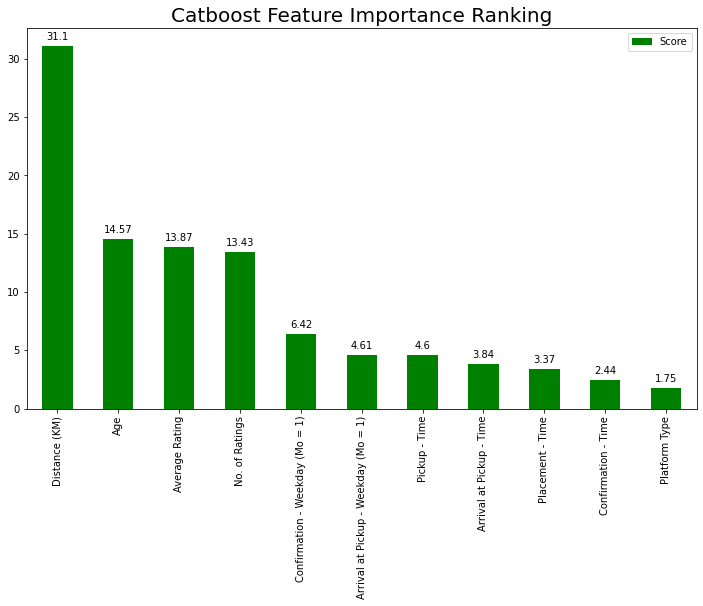

In [70]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='green')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 20)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

##**3.4. Fitting the models**

In [73]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet

regEN = ElasticNet(alpha=0.00009, tol=0.00001, l1_ratio = 0.9,
                 max_iter=100, normalize = True, random_state=32)
regEN.fit(x_trainer, y_trainer)
cvsEN = cross_val_score(regEN, x_trainer, y_trainer, cv=5)

print(cvsEN)
print(np.mean(cvsEN))

[0.34970622 0.32486457 0.33757297 0.35451374 0.3254278 ]
0.3384170584124431


In [74]:
from sklearn.linear_model import Lasso

regR = Lasso(tol=0.000001,  max_iter=1000,  random_state=32)
regR.fit(x_trainer, y_trainer)
cvsR = cross_val_score(regEN, x_trainer, y_trainer, cv=100)

print(cvsR)
print(np.mean(cvsR))

[0.28299688 0.44754682 0.38467176 0.34440934 0.21132885 0.41871978
 0.32115495 0.39053555 0.35259012 0.26107296 0.30278525 0.33578313
 0.40650364 0.46890904 0.39121043 0.31227553 0.33796549 0.27042428
 0.24479852 0.41104678 0.39284522 0.33661323 0.36765149 0.27560887
 0.49441728 0.34776555 0.35294155 0.27354666 0.27141929 0.38467341
 0.37590675 0.39052069 0.21755439 0.32397408 0.25890673 0.20267501
 0.20924575 0.3153095  0.29964494 0.34336009 0.33836224 0.37137159
 0.41445939 0.30227164 0.387208   0.49124822 0.29966525 0.40382701
 0.22622973 0.36510085 0.25653283 0.42165768 0.24140167 0.29534744
 0.27064244 0.43975717 0.24176516 0.2980645  0.39514683 0.20064536
 0.42212281 0.23178274 0.31957237 0.28834204 0.36313917 0.25790279
 0.37801641 0.36954161 0.35456116 0.46900132 0.46218909 0.2999072
 0.2473853  0.2734673  0.37124175 0.45903733 0.31048996 0.36227295
 0.42535738 0.36618814 0.22992989 0.32497857 0.34736819 0.3373879
 0.32858779 0.25009031 0.30231782 0.19875498 0.30441674 0.423527

In [75]:
from sklearn.ensemble import ExtraTreesRegressor

regET = ExtraTreesRegressor(n_estimators = 100, criterion = 'mse', min_weight_fraction_leaf=0.001 , random_state=32, n_jobs=-1)
regET.fit(x_trainer, y_trainer)
cvsET = cross_val_score(regET, x_trainer, y_trainer, cv=10)

print(cvsET)
print(np.mean(cvsET))

[0.36224605 0.36612046 0.38255472 0.31881604 0.37449474 0.33092038
 0.35740665 0.38608666 0.33655276 0.36289096]
0.35780894287309023


##**3.5. Combining the fitted models to increase our model performance**

In [76]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

models = [("LA",regR),('CA', cata),('ET', regET)]
meta_learner_reg = regEN

s_reg = StackingRegressor(estimators=models, final_estimator=meta_learner_reg, passthrough = True)
s_reg.fit(x_trainer, y_trainer)
s_cvs = cross_val_score(s_reg, x_trainer, y_trainer, cv=5)

print(s_cvs)
print(np.mean(s_cvs))

0:	learn: 961.5762262	total: 28.6ms	remaining: 17.1s
20:	learn: 789.7731285	total: 296ms	remaining: 8.15s
40:	learn: 767.8885102	total: 587ms	remaining: 8s
60:	learn: 756.7323420	total: 882ms	remaining: 7.8s
80:	learn: 748.1254657	total: 1.19s	remaining: 7.61s
100:	learn: 738.3575786	total: 1.5s	remaining: 7.41s
120:	learn: 729.0654888	total: 1.81s	remaining: 7.16s
140:	learn: 719.1911164	total: 2.12s	remaining: 6.9s
160:	learn: 709.1576204	total: 2.42s	remaining: 6.59s
180:	learn: 701.7946147	total: 2.72s	remaining: 6.29s
200:	learn: 693.1440742	total: 3.02s	remaining: 6s
220:	learn: 685.7273202	total: 3.33s	remaining: 5.71s
240:	learn: 678.6161516	total: 3.63s	remaining: 5.42s
260:	learn: 671.9918086	total: 3.94s	remaining: 5.12s
280:	learn: 665.2676530	total: 4.24s	remaining: 4.81s
300:	learn: 658.4350826	total: 4.54s	remaining: 4.51s
320:	learn: 651.3994449	total: 4.85s	remaining: 4.21s
340:	learn: 645.0188302	total: 5.16s	remaining: 3.92s
360:	learn: 639.4194351	total: 5.47s	remai

#4. **Performance Evaluation**

##**4.1. Comparing the prected values by each model**

In [4]:
'''
****
*****
******
********
'''
#Super Learner 
y_predS = s_reg.predict(x_test2)

y_predS

NameError: name 's_reg' is not defined

In [78]:
#Extra Trees 
y_predET = regET.predict(x_tester)

y_predET

array([1830.55906561, 1530.6997297 , 1207.36226068, ..., 2344.91377556,
        838.372918  , 1063.93646723])

In [79]:
#RLasso 
y_predR = regR.predict(x_tester)

y_predR

array([1819.4722962 , 1404.95753975, 1030.5670644 , ..., 2514.99461793,
        769.54775057, 1045.00374143])

In [80]:
#Elastic Net
y_predEN = regEN.predict(x_tester)

y_predEN

array([1789.20593748, 1373.99841308, 1097.67274024, ..., 2387.62160622,
        959.83814271, 1109.92857796])

In [81]:
#CatBoost
zoo = cata.predict(x_tester)

zoo

array([1897.5747149 , 1544.40584777, 1015.70278052, ..., 2409.01934316,
        697.59113017,  979.9304584 ])

#**Conclusion**
##**Model Analysis**

In [ ]:
from sklearn import metrics

print('r2 Score:', metrics.r2_score(y_tester, y_predS))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_tester, y_predS))
print('Mean Squared Error:', metrics.mean_squared_error(y_tester, y_predS))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_tester, y_predS)))

##**Writing Results Data**

In [83]:
testid = test.index
testid

Index(['Order_No_19248', 'Order_No_12736', 'Order_No_768', 'Order_No_15332',
       'Order_No_21373', 'Order_No_14573', 'Order_No_6731', 'Order_No_18436',
       'Order_No_2288', 'Order_No_9063',
       ...
       'Order_No_25241', 'Order_No_5287', 'Order_No_7712', 'Order_No_294',
       'Order_No_16972', 'Order_No_3612', 'Order_No_7657', 'Order_No_1969',
       'Order_No_10591', 'Order_No_1603'],
      dtype='object', name='Order No', length=7068)

In [84]:
d = {'ID': testid, 'Delivery Time':np.round(y_predS, 0)}
sub = pd.DataFrame(data=d)
sub = sub[['ID', 'Delivery Time']]
sub


,ID,Delivery Time
0,Order_No_19248,1667.0
1,Order_No_12736,1207.0
2,Order_No_768,1141.0
3,Order_No_15332,1244.0
4,Order_No_21373,1191.0
...,...,...
7063,Order_No_3612,1248.0
7064,Order_No_7657,2867.0
7065,Order_No_1969,1651.0
7066,Order_No_10591,2425.0


In [ ]:
sub.to_csv("sub_1.csv",index  = False)